In [1]:


import string
import re
import itertools

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, rgb2hex
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

from wordcloud import WordCloud, ImageColorGenerator

import networkx as nx

from circos import CircosPlot

import re

In [3]:
#data = pd.read_csv('test_MA-albums_2019-09-13.csv', index_col=0) # Change the date to match the date you scraped!
data = pd.read_csv('MA-albums_2019-09-13.csv', index_col=0)

In [65]:
data.head()
cd='CD'
vinyl='12" vinyl'
#data.query('Format == @cd',inplace=True)

In [85]:
def checkSplit(split):
    markedAsAddition = (split.find('(')>-1
        or split.find(')')>-1
        or split.find(',')>-1        
        or split.find('.')>-1     
        or split.find(' ')>-1                          
        or split.find('influenced')>-1
        or not split
    )
    return markedAsAddition

def genreDefinition(longGenre):
    if(longGenre.find('NWOBHM')>-1):
        return 'NWOBHM'
    if(longGenre.find('Thrash')>-1):
        return 'Thrash'
    if(longGenre.find('Hard Rock')>-1 and longGenre.find('Heavy Metal')>-1):
        return 'Heavy'
    if(longGenre.find('Power Metal')>-1):
        return 'Power'
    
    splittedGenre = longGenre.replace('Metal','').replace('metal','').split(' ')

    mainGenrePos=-1
    while checkSplit(splittedGenre[mainGenrePos]):
        mainGenrePos+=-1
    mainGenre = splittedGenre[mainGenrePos]
    mainGenre = mainGenre.split('/')
    mainGenrePos=0
    while checkSplit(mainGenre[mainGenrePos]):
        mainGenrePos+=1
    return mainGenre[mainGenrePos]

def genreSplit(longGenre):
    splits=re.split(' |/|,|\.|;|:|-|with|With',longGenre.replace('Metal','').replace('metal',''))
    splits = [g for g in splits if (g and g.find('(')==-1 and g.find(')')==-1)]
    return splits

In [68]:
gs=genreDefinition('Black Metal (early), Black metal Metal/Noise/Goregrind eins/zwei Rock')

print gs

Rock


In [64]:
data_small=pd.DataFrame()
data_small['AlbumName']=data['AlbumLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
print('got Album Names')
data_small['BandName']=data['BandLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
#data_small['DateString']=data['Date'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser').text)
data_small['Year']=data['Date'].map(lambda raw_html: int(BeautifulSoup(raw_html, 'html.parser').text.split(' ')[-2]))
print('parsed Name and Date, start checking the main Genre')
data_small['GenreMain']=data['Genre'].map(
    lambda gen: genreDefinition(gen)
    )
data_small['GenreList']=data['Genre'].map(
    lambda gen: genreSplit(gen)
    )
n_prev=len(data_small)
print('got ',n_prev,' entries, check for duplicates')
data_small.drop_duplicates(['AlbumName','BandName','Year'],inplace=True)
print('Dropped ',n_prev-len(data_small),' abums as duplicates')
print('save the dropped as csv')
data_small.to_csv('MA-albums_2019-09-13_smallerWGenreSplit.csv', encoding='UTF-8')

got Album Names
parsed Name and Date, start checking the main Genre
('got ', 168735, ' entries, check for duplicates')
('Dropped ', 46025, ' abums as duplicates')
save the dropped as csv


In [2]:
data_small=pd.read_csv('MA-albums_2019-09-13_smallerWGenreSplit.csv', index_col=0)

In [3]:
data_small.head()


,AlbumName,BandName,Year,GenreMain,GenreList
0,Shades of Deep Purple,Deep Purple,1968,Heavy,"[Heavy, Hard, Rock]"
2,The Book of Taliesyn,Deep Purple,1968,Heavy,"[Heavy, Hard, Rock]"
3,Ĺ˝elva,Olympic,1968,Heavy,"[Pop, Rock, Heavy, Hard, Rock]"
7,Deep Purple,Deep Purple,1969,Heavy,"[Heavy, Hard, Rock]"
8,Shades of Deep Purple,Deep Purple,1969,Heavy,"[Heavy, Hard, Rock]"


In [70]:
dataAlph=data_small.sort_values('AlbumName')
dataAlph.head()
    


,AlbumName,BandName,Year,GenreMain,GenreList
23962,!Explosive! 4-7494-9001-00,Foursection,1998,Thrash,"[Death, Thrash]"
70005,!Ãºl..,!Ãºl..,2007,Death,"[Death, Black]"
145767,!​!​!​! The Leader of Doom !​!​!​!,Malignus Morttvss,2017,Noise,"[Black, Black, Noise, Goregrind]"
114726,"""1013""",Rising Crypts,2013,Death,[Death]
45584,"""Arachnoidea oder: Von Babalon, Scheiterhaufen...",Samsas Traum,2003,Neoclassical,"[Gothic, Avant, garde, Black, Neoclassical, Da..."


In [92]:
all_terms = data_small['GenreMain']      # Flatten terms to a single list
unique_terms, counts = np.unique(all_terms, return_counts=True)          # Get unique terms & counts
genre_terms = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count

In [93]:
len(genre_terms)

112

In [60]:
all_terms = data['Genre']      # Flatten terms to a single list
unique_terms, counts = np.unique(all_terms, return_counts=True)          # Get unique terms & counts
genre_terms = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count

In [240]:
all_terms = data_small['GenreList']   # Flatten terms to a single list
all_terms_flat=pd.Series([i for j in all_terms for i in j])
#all_terms.apply(pd.Series).stack().reset_index(drop=True)
unique_terms, counts = np.unique(all_terms_flat, return_counts=True)          # Get unique terms & counts
genre_terms_more = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms_more.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count
print len(genre_terms_more)
core='core'
genre_terms_more.query('Term==@core')

183


,Term,TotalCount
173,core,2766


In [289]:
print data_small.loc[data_small.index[-1]]['Year']

2019


In [19]:
len(data_small['GenreMain'].value_counts())

113

In [20]:
data_small['Year'].value_counts()

2015    7234
2014    7153
2016    7083
2017    7035
2013    6863
2018    6594
2012    6346
2011    5874
2010    5589
2008    5475
2009    5379
2007    5032
2006    4516
2005    4414
2019    4225
2004    3896
2003    3550
2002    3343
2001    2693
2000    2341
1999    2173
1998    2011
1997    1825
1996    1612
1995    1366
1994    1284
1993    1078
1991     854
1992     826
1990     796
1989     691
1988     664
1987     574
1986     540
1985     502
1984     363
1983     248
1982     167
1981     128
1980      89
1978      48
1979      43
1977      39
1976      38
1974      27
1973      22
1975      22
1972      18
1971      13
1970       7
1969       4
1968       3
Name: Year, dtype: int64

In [292]:
y85=1985
data_small.query('Year == @y85')['GenreMain'].value_counts()['Heavy']

260

In [4]:
read=True
if(not read):
    yearList=data_small['Year'].value_counts().keys().sort_values()
    GenreList=data_small['GenreMain'].value_counts().keys()
    GenreYearCount=pd.DataFrame(0,index=yearList, columns=GenreList)
    GenreYearCount['other']=0
    for y in yearList:
        yearCounts=data_small.query('Year == @y')['GenreMain'].value_counts()
        for i,(g,v) in enumerate(zip(yearCounts.keys(),yearCounts)):
            if i < 10:
                GenreYearCount[g][y]=v
            else:
                GenreYearCount['other'][y]+=v

    for g in GenreYearCount.columns:
        if GenreYearCount[g].sum()==0:
            del GenreYearCount[g]             
        
    GenreYearCount.to_csv('GenreYearCount_.csv')
else:
    GenreYearCount = pd.read_csv('GenreYearCount_.csv', index_col=0)
GenreYearCountNorm=GenreYearCount.apply(lambda x: x/x.sum()*100, axis=1)
yearSum=pd.DataFrame(data_small['Year'].value_counts())
yearSum.sort_index(inplace=True)

In [5]:
read=True
if(not read):
    yearList=data_small['Year'].value_counts().keys().sort_values()
    GenreListMore=genre_terms_more['Term']
    GenreYearCountMore=pd.DataFrame(0,index=yearList, columns=GenreListMore)
    GenreYearCountMore['other']=0
    for y in yearList:
        yearCounts=pd.Series([i for j in data_small.query('Year == @y')['GenreList'] for i in j]).value_counts()
        for i,(g,v) in enumerate(zip(yearCounts.keys(),yearCounts)):
            if i < 10 or GenreYearCountMore[g].sum()>0:
                GenreYearCountMore[g][y]=v
            else:
                GenreYearCountMore['other'][y]+=v

    for g in GenreYearCountMore.columns:
        if GenreYearCountMore[g].sum()==0:
            del GenreYearCountMore[g]
    GenreYearCountMore.to_csv('GenreYearCountFlatDef.csv')
else:
        GenreYearCountMore=pd.read_csv('GenreYearCountFlatDef.csv',index_col=0)
GenreYearCountMoreNorm=GenreYearCountMore.apply(lambda x: x/x.sum()*100, axis=1)
smallGenresToClean = ['Gospel', 'Blues', 'Various', 'Pop', 'Punk']
for cl in smallGenresToClean:
    try:
        del GenreYearCountMoreNorm[cl] 
    except:
                pass

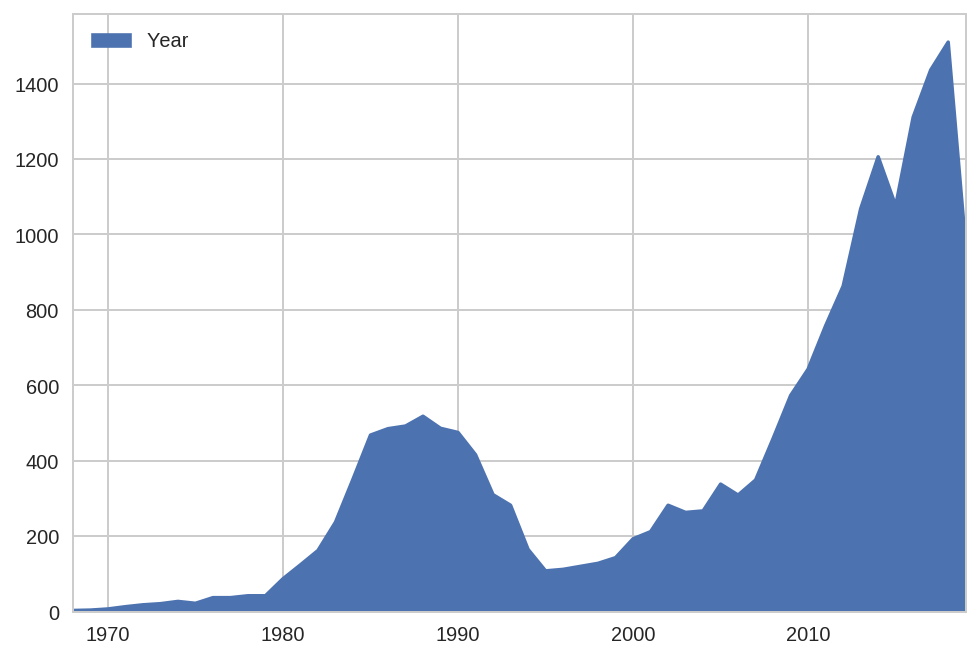

In [44]:
yearSum.plot.area()

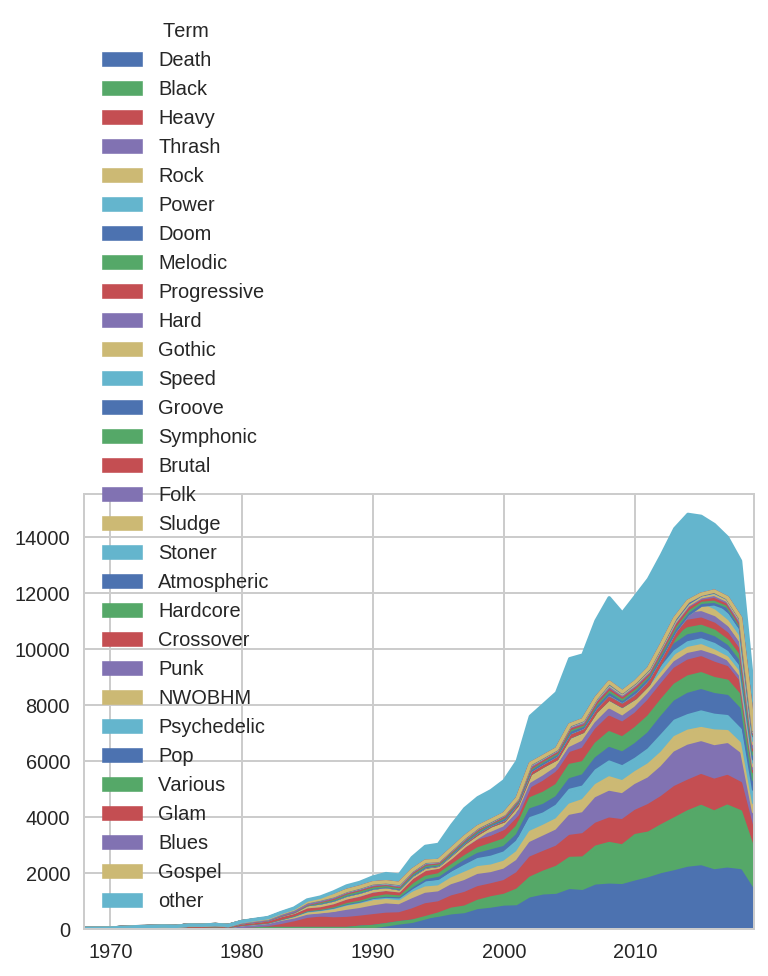

In [112]:
GenreYearCountMore.plot.area()

In [335]:
GenreYearCountNorm=GenreYearCount.apply(lambda x: x/x.sum()*100, axis=1)

In [ ]:
yearSum.loc[2019]['Year']

In [9]:
colorsDic={'Death': u'dimgrey','Black':u'black','Power':u'crimson',
           'Gothic':u'olive','Thrash':u'red', 'NWOBHM':u'gold',
           'Rock':u'green','Heavy':u'blue', 'other': 'white', 'Doom':u'lightgoldenrodyellow','Brutal':u'black',
          'Folk':'green' }
badcol = [u'sienna', u'sandybrown', u'bisque', u'blanchedalmond', u'wheat', u'cornsilk',
           u'k', u'w',u'snow',u'd']
from __future__ import division

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
sorted_names.reverse()
sorted_names = [s for s in sorted_names if ((not s in colorsDic.values()) and (not s in badcol) and s.find('gray')<0 and s.find('grey')<0 and s.find('white')<0 )]
sorted_names=sorted_names[0::4]
colors=[]
for key in GenreYearCountMoreNorm.columns:
    if key in colorsDic:
        colors=colors+[colorsDic[key]]
    else:
        colors=colors+[sorted_names.pop()]
        
print colors

[u'dimgrey', u'black', u'blue', u'red', u'green', u'crimson', u'lightgoldenrodyellow', u'rosybrown', u'firebrick', u'mistyrose', u'olive', u'coral', u'chocolate', u'linen', u'black', 'green', u'papayawhip', u'darkgoldenrod', u'palegoldenrod', u'lightyellow', u'yellowgreen', u'gold', u'lawngreen', u'lightgreen', 'white']


start adding Genre tags


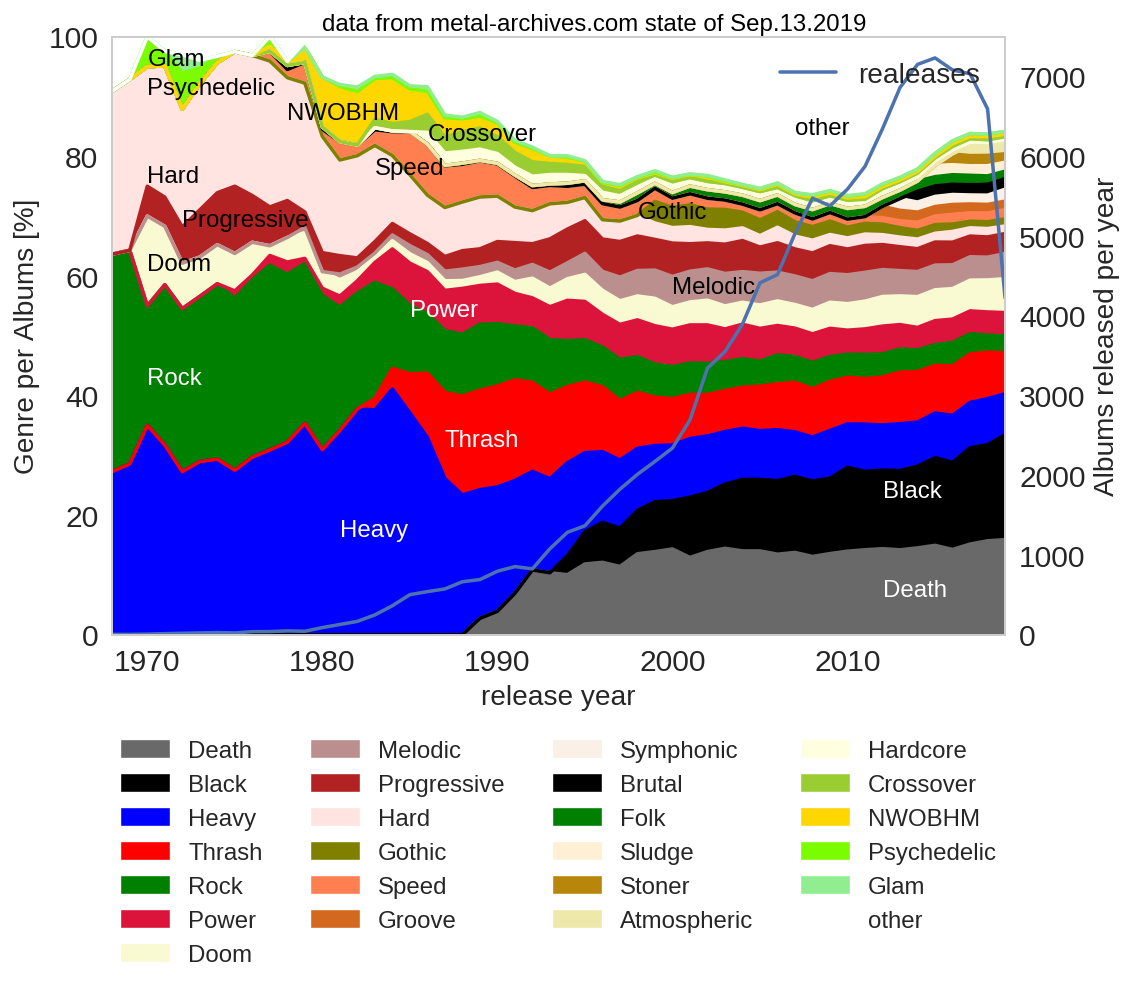

In [14]:
smallGenresToClean = ['Gospel', 'Blues', 'Various', 'Pop', 'Punk']
for cl in smallGenresToClean:
    try:
        del GenreYearCountMoreNorm[cl] 
    except:
                pass

ax=plt.gca()
#fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
#fig.subplots_adjust(right=0.8)

GenreYearCountMoreNorm.plot.area(ax=axes[0], colors=colors)

#yearSum.loc[2019]['Year']=12./8.5*yearSum.loc[2019]['Year']
yearSum.plot.line(ax=axes[1])
axes[0].plot()
axes[1].plot()
axes[0].set_xlabel('release year', fontsize=14)#
axes[1].set_xlabel('year')
axes[0].set_ylabel('Genre per Albums [%]', fontsize=14)
axes[1].set_ylabel('Albums released per year', fontsize=14)

axes[0].grid(False)
axes[1].grid(False)
axes[0].set_ylim([0,100])
axes[1].set_ylim([0,7500])

axes[0].xaxis.set_tick_params(labelsize=15)
axes[0].yaxis.set_tick_params(labelsize=15)
axes[1].yaxis.set_tick_params(labelsize=15)

lgd1=axes[1].legend(loc='upper right',labels=['realeases'], prop={'size': 14})
lgd2=axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), ncol=4, prop={'size': 12})

yOffsetsum = 0.
color='w'
print 'start adding Genre tags'
for name in GenreYearCountMoreNorm.columns:
    if name=='Doom':
        color='k'
    locx = GenreYearCountMoreNorm[name].idxmax()  
    locy = GenreYearCountMoreNorm[name][locx]
    if locy<3.:
        continue
    axes[0].text(max(min(2015,locx)-3,1970),GenreYearCountMoreNorm.loc[locx,:name].sum()-(locy*0.6),name, color=color)

t1=axes[0].text(1980,101,'data from metal-archives.com state of Sep.13.2019',color='k')

plt.savefig('outputGenreSplits.png', bbox_extra_artists=(lgd1,lgd2,t1), bbox_inches='tight', dpi=300)

In [257]:
GenreYearCountMoreNorm.loc[2018,:'Thrash'].sum()


Term
Death     15.704616
Black     16.069663
Heavy      7.704008
Thrash     7.772454
Name: 2018, dtype: float64

ax=plt.gca()
#fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
#fig.subplots_adjust(right=0.8)

GenreYearCountNorm.plot.area(ax=axes[0], colors=['k','gray','b','g','r',
                                                  'lightblue','w','darkviolet','olive','c','y','m',
                                                'tab:blue','tab:orange','tab:brown','tab:pink','tab:red','tab:green','wheat'])
yearSum.plot.line(ax=axes[1])
axes[0].plot()
axes[1].plot()
axes[0].set_xlabel('year')#
axes[1].set_xlabel('year')
axes[0].set_ylabel('Genre per Albums [%]')
axes[1].set_ylabel('Albums released per year')

plt.savefig('outputLongGenre.png')

In [174]:
a=[1,2,3,4]
a.reverse()
a.pop()
a

[4, 3, 2]